# **Use polygon coordinates to find building density and output a csv file.**

Comments:
1. The csv file contains the geometry column (polygons of the grid cells) and the building density column. <br>
2. 200m resolution is used.


In [12]:
pip install geopandas shapely pyproj rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 63.1 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [13]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, box
from shapely.ops import unary_union
from matplotlib.colors import LogNorm
import pyproj
import rasterio
from rasterio.features import rasterize

In [3]:
# Define the bounding box
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)

In [4]:
# Load the CSV with building data (polygon number, latitude, longitude)
csv_file = '/kaggle/input/polygon-coordinates/polygon_coordinates.csv'  
df = pd.read_csv(csv_file)

In [5]:
# Group the data by Polygon_Number and round to 6 decimal places
polygon_dict = (
    df.groupby("Polygon Number")
    .apply(
        lambda group: [
            (round(lon, 6), round(lat, 6)) for lon, lat in zip(group["Longitude"], group["Latitude"])
        ]
    )
    .to_dict()
)

# Generate polygons as a list
polygons = []
for coordinates in polygon_dict.values():
    if len(coordinates) > 2:  # Polygons require at least 3 points
        polygons.append(Polygon(coordinates))

# Display the first polygon as an example
print(polygons[1])
print(len(polygons))

<ipython-input-5-d0d109493a43>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


POLYGON ((-73.921952 40.849629, -73.921911 40.849679, -73.921764 40.84961, -73.921805 40.84956, -73.921952 40.849629))
9436


In [6]:
# Create a GeoDataFrame from the list of polygons
gdf = gpd.GeoDataFrame(geometry=polygons, crs="EPSG:4326")  # WGS 84 (Lat/Lon)

gdf

,geometry
0,"POLYGON ((-73.91903 40.84820, -73.91933 40.847..."
1,"POLYGON ((-73.92195 40.84963, -73.92191 40.849..."
2,"POLYGON ((-73.92050 40.85011, -73.92045 40.850..."
3,"POLYGON ((-73.92056 40.85140, -73.92053 40.851..."
4,"POLYGON ((-73.91234 40.85218, -73.91247 40.852..."
...,...
9431,"POLYGON ((-73.95267 40.77923, -73.95254 40.779..."
9432,"POLYGON ((-73.94964 40.77613, -73.94931 40.776..."
9433,"POLYGON ((-73.95210 40.76880, -73.95174 40.769..."
9434,"POLYGON ((-73.95230 40.75904, -73.95246 40.759..."


In [7]:
# Create a GeoDataFrame for the bounding box
bounding_box = gpd.GeoDataFrame(
    geometry=[box(lower_left[1], lower_left[0], upper_right[1], upper_right[0])],
    crs="EPSG:4326"
)

# Reproject to UTM (meters)
utm_proj = bounding_box.to_crs("EPSG:32618")  # Adjust UTM zone as needed

# Get bounding box in UTM
x_min, y_min, x_max, y_max = utm_proj.total_bounds

# Generate grid cells in meters
cell_size = 200  # 200 meters
x_coords = np.arange(x_min, x_max, cell_size)
y_coords = np.arange(y_min, y_max, cell_size)

grid_cells = []
for x in x_coords:
    for y in y_coords:
        grid_cells.append(box(x, y, x + cell_size, y + cell_size))

# Convert grid cells to GeoDataFrame
grid_gdf = gpd.GeoDataFrame(geometry=grid_cells, crs="EPSG:32618")

# Optional: Reproject back to WGS 84
grid_gdf = grid_gdf.to_crs("EPSG:4326")

# Output
print(grid_gdf.head())
print(grid_gdf.shape)

                                            geometry
0  POLYGON ((-74.00956 40.75000, -74.00954 40.751...
1  POLYGON ((-74.00954 40.75180, -74.00951 40.753...
2  POLYGON ((-74.00951 40.75360, -74.00948 40.755...
3  POLYGON ((-74.00948 40.75540, -74.00945 40.757...
4  POLYGON ((-74.00945 40.75720, -74.00943 40.759...
(4745, 1)


In [8]:
# Count buildings in each grid cell
building_density = []
for i, grid_cell in enumerate(grid_gdf.geometry):
    count = sum(grid_cell.intersects(building) for building in gdf.geometry)
    building_density.append(count)
    
    # Print progress every 100 grid cells 
    if i % 100 == 0:
        print(f"Processed {i} grid cells out of {len(grid_gdf)}")

# Add the density results to the grid GeoDataFrame
grid_gdf['density'] = building_density

Processed 0 grid cells out of 4745
Processed 100 grid cells out of 4745
Processed 200 grid cells out of 4745
Processed 300 grid cells out of 4745
Processed 400 grid cells out of 4745
Processed 500 grid cells out of 4745
Processed 600 grid cells out of 4745
Processed 700 grid cells out of 4745
Processed 800 grid cells out of 4745
Processed 900 grid cells out of 4745
Processed 1000 grid cells out of 4745
Processed 1100 grid cells out of 4745
Processed 1200 grid cells out of 4745
Processed 1300 grid cells out of 4745
Processed 1400 grid cells out of 4745
Processed 1500 grid cells out of 4745
Processed 1600 grid cells out of 4745
Processed 1700 grid cells out of 4745
Processed 1800 grid cells out of 4745
Processed 1900 grid cells out of 4745
Processed 2000 grid cells out of 4745
Processed 2100 grid cells out of 4745
Processed 2200 grid cells out of 4745
Processed 2300 grid cells out of 4745
Processed 2400 grid cells out of 4745
Processed 2500 grid cells out of 4745
Processed 2600 grid cell

In [9]:
grid_gdf

,geometry,density
0,"POLYGON ((-74.00956 40.75000, -74.00954 40.751...",0
1,"POLYGON ((-74.00954 40.75180, -74.00951 40.753...",0
2,"POLYGON ((-74.00951 40.75360, -74.00948 40.755...",0
3,"POLYGON ((-74.00948 40.75540, -74.00945 40.757...",0
4,"POLYGON ((-74.00945 40.75720, -74.00943 40.759...",0
...,...,...
4740,"POLYGON ((-73.85586 40.87109, -73.85583 40.872...",0
4741,"POLYGON ((-73.85583 40.87289, -73.85580 40.874...",0
4742,"POLYGON ((-73.85580 40.87469, -73.85577 40.876...",0
4743,"POLYGON ((-73.85577 40.87649, -73.85574 40.878...",0


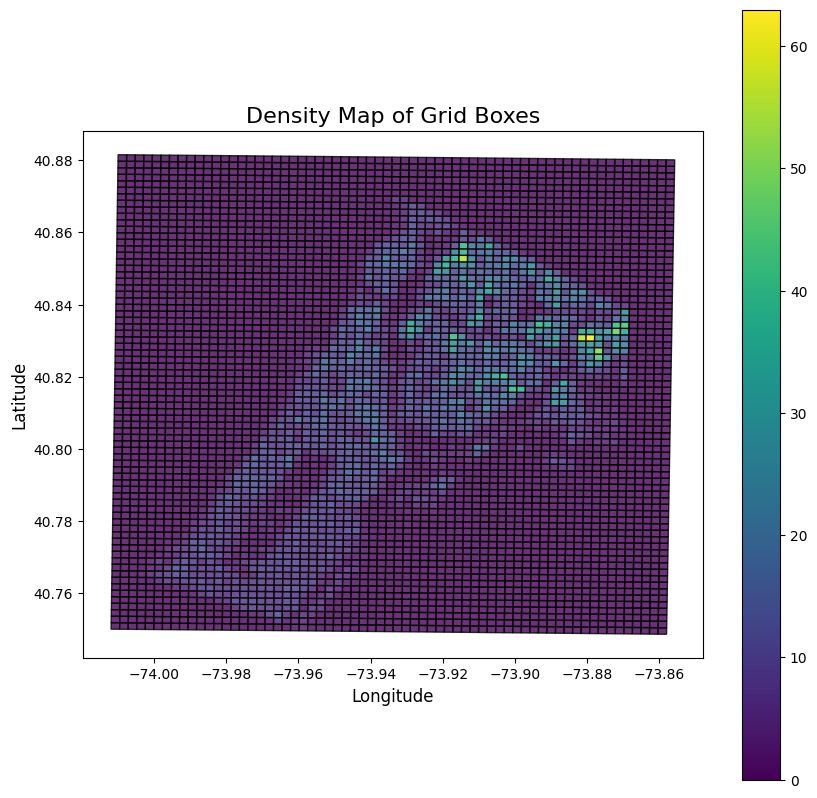

In [10]:
# Plot the data
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
grid_gdf.plot(column='density',  # The column to visualize
        cmap='viridis',    # Colormap for density values
        legend=True,       # Add a color bar legend
        ax=ax,             # Axes to plot on
        edgecolor='black', # Optional: add black edges to the polygons
        alpha=0.8)         # Transparency of the polygons

# Add titles and labels
ax.set_title('Density Map of Grid Boxes', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Optionally, adjust the axis aspect ratio for proper visualization
ax.set_aspect('equal', 'box')

# Show the plot
plt.show()


In [28]:
# Extract geometry and density data from the GeoDataFrame
grid_gdf['geometry_wkt'] = grid_gdf.geometry.apply(lambda geom: geom.wkt)

# Select only the relevant columns
csv_data = grid_gdf[['geometry_wkt', 'density']]

# Save to CSV
csv_file_path = 'grid_density.csv'
csv_data.to_csv(csv_file_path, index=False)

print(f"Grid data saved to {csv_file_path}")

Grid data saved to grid_density.csv
